### 1)Extraction des données 

In [1]:
import os
from os import listdir, path
import tarfile
import random
import numpy as np
import keras 
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#attention au path bien avoir une hierarchie : data -> Dossier suivant dans data : data_test.tar.gz ,data_train.tar.gz, data_train.csv 
if not path.exists('data/data_test/'):
    print('Extracting test image files...')
    tar = tarfile.open("./data/data_test.tar.gz", "r:gz")
    tar.extractall('data/')
if not path.exists('data/data_train/'):
    print('Extracting train image files...')
    tar = tarfile.open("./data/data_train.tar.gz", "r:gz")
    tar.extractall('data/')

### Display utility functions

In [2]:
def show(image):
    plt.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
    plt.title("image shape: "+ str(image.shape), fontsize=14)
    plt.axis('off');
    
def show_multiple(images, figsize):
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for col, image in zip(ax, images):
        col.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
        col.set_title("image shape: "+ str(image.shape), fontsize=14)
    plt.tight_layout()
    plt.axis('off');

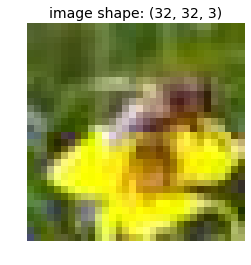

In [3]:
sample_image = imread("./data/data_train/10.jpg")
show(sample_image)

### Importer les Images (Train and Test) et les trier afin qu'elles soient en adéquation avec le fichier CSV

In [3]:
import pandas as pd

def load_data(data_path):
    csv_path = os.path.join(data_path, "labels_train.csv")
    return pd.read_csv(csv_path) # note the returned variable

In [4]:
GLOBAL_DATA_PATH = "./data"
data = load_data(GLOBAL_DATA_PATH) #Pemet de charger les données du CSV
#y_train = load_data(GLOBAL_DATA_PATH)

In [5]:
import shutil, os

def split_img_in_subfolders(data) :
    for i in range(data.shape[0]) : 
        animal_folder_path = os.path.join('./','data', 'data_train', data['Category'][i])
        
        # Create folder if doesn't exist 
        if not path.exists(animal_folder_path):
            os.mkdir(animal_folder_path)
            
        # Copy the img in the associated folder    
        shutil.copy(os.path.join('./', 'data', 'data_train', str(data['Id'][i])) +'.jpg', os.path.join(animal_folder_path , str(data['Id'][i]) +'.jpg'))

In [8]:
#split_img_in_subfolders(data)

In [5]:
def get_classes() :
    classes = []
    for animal in data['Category'] :
        if (animal not in classes) : 
            classes.append(animal)
        
    return classes

In [6]:
def get_splitted_data_with_size(image_size, sample_size, test_ratio, classes, seed):
    X, Y = [], []
    for label, animal in enumerate(classes):
        files = listdir(path.join('./data/data_train', animal))
        random.shuffle(files)
        files = files[:(sample_size // len(classes))]
        for file in files:
            img = load_img(path.join('./data/data_train', animal, file), 
                           target_size=image_size)
            X.append(img_to_array(img))
            Y.append(label)
            
    return train_test_split(np.asarray(X), np.asarray(Y), test_size=test_ratio, random_state=seed)

In [8]:
data.shape

(7200, 2)

In [ ]:
image_size = (100, 100, 3)
keras_size = (224, 224, 3)
sample_size = 2000
#sample_size = 400
classes = get_classes()

X_tr, X_val, y_tr, y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=sample_size, test_ratio=0.25, classes=classes, seed=42
)

In [8]:
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((742, 75, 75, 3), (248, 75, 75, 3), (742,), (248,))

In [14]:
len(classes)

15

dolphin


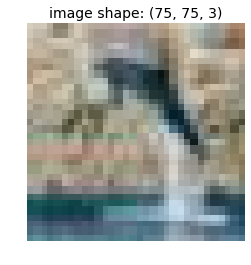

In [8]:
show(X_tr[4])
print(classes[y_tr[4]])

chimpanzee


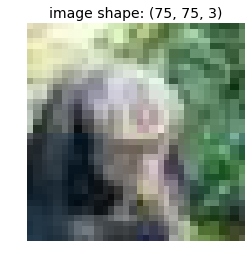

In [9]:
show(X_val[4])
print(classes[y_val[4]])

### MODEL : VIA RESNET 50 

In [8]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

#train_datagen = ImageDataGenerator() 
#train_generator = train_datagen.flow_from_directory(my_input_dir, target_size=(150,150),shuffle=False, batch_size=16)

    # get bottleneck features
    # use pre-trained model and exclude top layer - which is used for classification
pretrained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=X_tr.shape[1:], pooling='avg')
#bottleneck_features_train_v1 = pretrained_model.predict_generator(tr_generator,len(tr_generator.filenames)//16, pooling='avg')

In [21]:
X_tr.shape[1:]

(75, 75, 3)

In [26]:
np.asarray(X_test).shape

(1800, 32, 32, 3)

In [13]:
if pretrained_model : 
    X_pretrained_tr = pretrained_model.predict(preprocess_input(X_tr), verbose=1)
    X_pretrained_val = pretrained_model.predict(preprocess_input(X_val), verbose=1)
    
    print('Done extracting Inception V3 features..')

499/499 [==============================] - 10s 20ms/step
Done extracting Inception V3 features..


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers
from keras import utils as np_utils



model = Sequential()

"""

model.add(Conv2D(64, (2, 2), padding='SAME')) 
model.add(Activation('relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2), padding='SAME')) 
model.add(Activation('relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))"""


"""
model.add(Conv2D(128, (4, 4), padding='SAME')) 
model.add(Activation('relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='SAME')) 
model.add(Activation('relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))"""


#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(GlobalAveragePooling2D())
model.add(Dense(len(classes), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#optimizers.SGD(lr=1e-4, momentum=0.9)
y_tr_temp = np_utils.to_categorical(y_tr, len(classes))
y_val_temp = np_utils.to_categorical(y_val, len(classes))

In [35]:
X_pretrained_tr.shape
from keras import backend as K
K.set_learning_phase(0)

In [48]:
X_pretrained_tr.shape

(742, 2048)

In [15]:
model_history = model.fit(
    x=X_pretrained_tr, 
    y=y_tr_temp, 
    batch_size=32,
    epochs=50,
    verbose=1,
    validation_data=(X_pretrained_val, y_val_temp))

Train on 1496 samples, validate on 499 samples
Epoch 1/50
1496/1496 [==============================] - 1s 731us/step - loss: 2.7567 - acc: 0.0635 - val_loss: 2.7253 - val_acc: 0.0481
Epoch 2/50
1496/1496 [==============================] - 0s 112us/step - loss: 2.7527 - acc: 0.0642 - val_loss: 2.7509 - val_acc: 0.0721
Epoch 3/50
1496/1496 [==============================] - 0s 116us/step - loss: 2.7567 - acc: 0.0615 - val_loss: 2.7296 - val_acc: 0.0701
Epoch 4/50
1496/1496 [==============================] - 0s 117us/step - loss: 2.7506 - acc: 0.0588 - val_loss: 2.7558 - val_acc: 0.0481
Epoch 5/50
1496/1496 [==============================] - 0s 114us/step - loss: 2.7417 - acc: 0.0648 - val_loss: 2.7606 - val_acc: 0.0701
Epoch 6/50
1496/1496 [==============================] - 0s 115us/step - loss: 2.7305 - acc: 0.0689 - val_loss: 2.7810 - val_acc: 0.0541
Epoch 7/50
1496/1496 [==============================] - 0s 117us/step - loss: 2.7474 - acc: 0.0628 - val_loss: 2.7400 - val_acc: 0.0882
E

In [47]:
batch_size = 32
num_epochs = 20

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_tr)
tr_generator = datagen.flow(X_tr, y_tr_temp, batch_size=32)
val_generator = datagen.flow(X_val, y_val_temp, batch_size=32)

In [14]:
X_tr.shape[0]

596

In [54]:

# fine-tune the model
model_history_augment = model.fit_generator(
    tr_generator,
    steps_per_epoch=500,
    epochs=2,
    validation_data=val_generator,
    validation_steps=500)

Epoch 1/2
500/500 [==============================] - 428s 856ms/step - loss: 2.2942 - acc: 0.2589 - val_loss: 2.3950 - val_acc: 0.2456
Epoch 2/2
500/500 [==============================] - 453s 907ms/step - loss: 1.9881 - acc: 0.3428 - val_loss: 2.1331 - val_acc: 0.3183


In [48]:
y_val.shape

(248, 15, 15, 15)

In [42]:
X_tr.shape[1:]

(32, 32, 3)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                30735     
Total params: 30,735
Trainable params: 30,735
Non-trainable params: 0
_________________________________________________________________


In [14]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax, metric, name in zip(axs, ['acc', 'loss'], ['Accuracy', 'Loss']):
        ax.plot(
            range(1, len(model_history.history[metric]) + 1), 
            model_history.history[metric]
        )
        ax.plot(
            range(1, len(model_history.history['val_' + metric]) + 1), 
            model_history.history['val_' + metric]
        )
        ax.set_title('Model ' + name)
        ax.set_ylabel(name)
        ax.set_xlabel('Epoch')
        ax.legend(['train', 'val'], loc='best')
    plt.show()

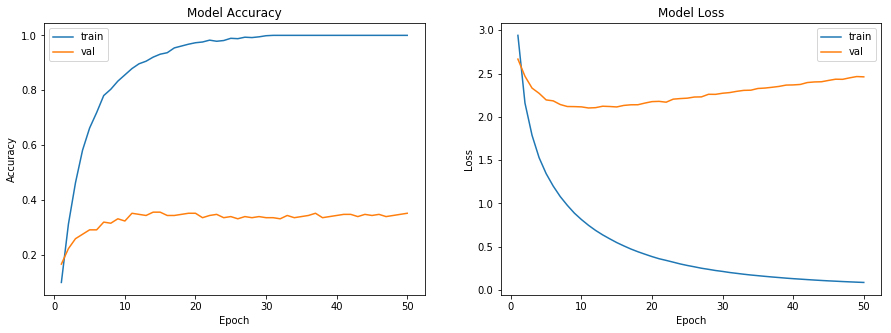

In [15]:
plot_model_history(model_history)

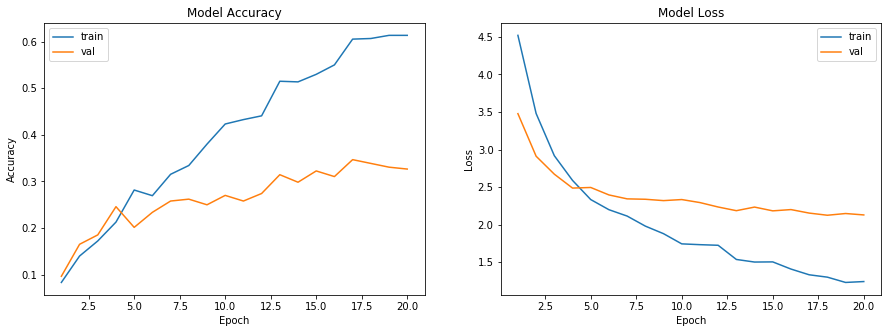

In [73]:
plot_model_history(model_history)

## Prediction

In [16]:
def conv(v):
    v2 = [s.strip('.jpg') for s in v] # remove the .jpg from the string borders 
    v2 = list(map(int, v2))
    return v2

In [17]:
def int_to_imagepath (v):
    v1 = list(map(str, v))
    #print (v1)
    v1 = [s.replace(s,s+".jpg") for s in v1] 
    return v1

In [18]:
X_test = []
files = []
files_test = listdir(path.join(GLOBAL_DATA_PATH, "data_test"))
files2_test = conv(files_test) # convertion string to int
files3_test = sorted(files2_test) # classement ordre croissant
files4_test = int_to_imagepath (files3_test)

for file in files4_test:
    img = load_img(path.join(GLOBAL_DATA_PATH, "data_test", file), target_size=(75, 75))
    X_test.append(img_to_array(img))

print("X_test lenght : ",len(X_test))

X_test lenght :  1800


In [19]:
X_pretrained_test = pretrained_model.predict(preprocess_input(np.asarray(X_test)), verbose=1)

1800/1800 [==============================] - 20s 11ms/step


In [39]:
print(np.asarray(X_test).shape)

(1800, 75, 75, 3)


In [58]:
X_pretrained_tr.shape

(742, 2048)

array([], shape=(0, 1), dtype=float64)

In [20]:
y_test = model.predict_classes(X_pretrained_test)
y_test_string = []

for i in range(y_test.shape[0]) : 
    y_test_string.append(classes[y_test[i]])

In [21]:
X_id = []
for i in range(y_test.shape[0]) : 
    X_id.append(i)

In [22]:
d = {'Id': X_id, 'Category': y_test_string}
test_df = pd.DataFrame(data = d)
test_df.to_csv('submission.csv', index=False)

In [23]:
test_df

,Id,Category
0,0,bee
1,1,wolf
2,2,bee
3,3,bear
4,4,butterfly
5,5,rabbit
6,6,squirrel
7,7,squirrel
8,8,fox
9,9,bee


In [75]:
import csv

id = 23
animal = 'chimpanzee'

with open('submition.csv', 'w', newline='') as csvfile:
    
    spamwriter = csv.writer(csvfile, delimiter='',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow({'Id,Category'})
    
    for i in range(4) : 
    
        spamwriter.writerow({i,',',classes[y_test[i]]})


In [50]:
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
from skimage.transform import resize
from skimage.io import imread

In [67]:
 #Basic Implementation of resnet model
model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
model_ResNet50.layers.pop()
#model_ResNet50.summary()

In [68]:
model_ResNet50.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [102]:
#print(X_tr)
#print(y_tr)

In [69]:
if model_ResNet50:
    X_extracted_tr = model_ResNet50.predict(preprocess_input(X_tr), verbose=1)
    X_extracted_val = model_ResNet50.predict(preprocess_input(X_val), verbose=1)
    print('Done extracting resnet50 features..')

248/248 [==============================] - 66s 267ms/step
Done extracting resnet50 features..


In [36]:
print("X_extracted_tr : ", X_extracted_tr.shape)

X_extracted_tr :  (67, 1000)


In [28]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [223]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.optimizers import Adam

batch_size = 128
num_epochs = 20

transfer_model = Sequential()

kernel_height = 5
kernel_width = 5
output_filter = 32
output_filter2 = 64
input_image = (image_size[0], image_size[1], image_size[2])
activation1 = 'relu'
activation2 = 'sigmoid'

"""
# TODO: 1st Convolution Layer
transfer_model.add(Conv2D(output_filter2, (kernel_height, kernel_width), padding='SAME', input_shape=(image_size[0], image_size[1], image_size[2]))) 
transfer_model.add(Activation('relu')) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

#2nd Convolution Layer
transfer_model.add(Conv2D(output_filter2, (kernel_height, kernel_width)))
transfer_model.add(Activation(activation1)) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

transfer_model.add(Flatten())
transfer_model.add(Dropout(0.5))
#transfer_model.add(Dense(128, activation = 'relu'))
transfer_model.add(Dense(1, activation = 'sigmoid'))"""



transfer_model.add(Conv2D(output_filter, (kernel_height, kernel_width), padding='SAME', input_shape=input_image)) 
transfer_model.add(Activation('relu')) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

transfer_model.add(Conv2D(output_filter2, (3, 3), padding='SAME', input_shape=input_image)) 
transfer_model.add(Activation('relu')) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

transfer_model.add(Flatten())
transfer_model.add(Dropout(0.4))
transfer_model.add(Dense(126, activation='relu'))
transfer_model.add(Dropout(0.25))
#transfer_model.add(Dense(10, activation='softmax'))
transfer_model.add(Dense(1))

    
transfer_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])